In [501]:
# used to reload the imported modules on save
%load_ext autoreload
%autoreload 2

import utils as u

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [502]:
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
import numpy as np
import cv2
import os

In [503]:
# constants
grid_size = (8,11)
square_size = 11

# getting the images path
images_path = "../images_and_poses_for_project_assignment/"
images_path = [os.path.join(images_path, imagename) for imagename in os.listdir(images_path) if imagename.endswith(".png")]

## Exercise 1

In [504]:
V = []
all_H = []  # saving the homographies for each image

# getting the homographies
for img in images_path:
    _, H = u.get_homography(img, grid_size, square_size)
    all_H.append(H)
    
    v_12 = u.get_v_vector(H, 1, 2)
    v_11 = u.get_v_vector(H, 1, 1)
    v_22 = u.get_v_vector(H, 2, 2)
    
    V.append(v_12)
    V.append(v_11 - v_22)
    
# computing params
V = np.array(V)
K = u.get_intrinsic(V)

# computing extrinsic for one image
all_R = []
all_t = []

for H in all_H:
    R, t = u.get_extrinsic(K, H)
    all_R.append(R)
    all_t.append(t)

# TODO: make a better log
print("Example params: \n")
print(f"- K -\n{K}\n")
print(f"- R -\n{all_R[0]}\n")
print(f"- t - \n{all_t[0]}\n")


Example params: 

- K -
[[1.01843862e+03 4.23642989e+00 6.40932090e+02]
 [0.00000000e+00 1.01903697e+03 3.68015516e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

- R -
[[ 0.93553167  0.15868745 -0.31559276]
 [ 0.03522997 -0.93087626 -0.36363201]
 [-0.35148164  0.32907094 -0.87645477]]

- t - 
[-40.39962025  54.00745131 397.88786277]



## Exercise 2

In [505]:
# getting the image and extrinsics
img_path = images_path[1]
R1 = all_R[1]
t1 = all_t[1]

# combining R and t
P = u.get_projection_matrix(K, R1, t1)

corners = u.get_corners(img_path, grid_size)
projected_corners = []

error = 0
for index, corner in enumerate(corners):
    u_coord = corner[0]
    v_coord = corner[1]

    grid_size_cv2 = tuple(reversed(grid_size))
    u_index, v_index = np.unravel_index(index, grid_size_cv2)

    # the coordinates of the corner w.r.t. the reference corner at position (0,0) of the corners array
    x_mm = (u_index) * square_size
    y_mm = (v_index) * square_size

    point_m = np.array([x_mm, y_mm, 0, 1])

    projected_u, projected_v = u.project(point_m, P)[0]
    projected_corners.append((projected_u, projected_v))
    
    error += (projected_u - u_coord)**2 + (projected_v - v_coord)**2

print(f"Error: {error:.2f}")
print(f"Mean error per corner: {error/len(corners):.2f}")

# showing the projected corners
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # type: ignore

for corner in projected_corners:
    u_coord, v_coord = int(corner[0]), int(corner[1])
    cv2.circle(image_rgb, (u_coord, v_coord), radius=5, color=(255, 0, 0), thickness=-1)

px.imshow(image_rgb)

Error: 30.01
Mean error per corner: 0.34


### Exercise 3

In [506]:
import random

random.seed(0)
NUM_IMAGES_TO_PROCESS = 25

images_indices = random.sample(range(len(images_path)), NUM_IMAGES_TO_PROCESS)

# 3D parameters of the cylinder (remain fixed for all projections)
radius_mm = 22.0
height_mm = 80.0

# Positioning consistent with the origin of the checkerboard (e.g. 4 squares, 4 squares)
center_x_mm = 5 * square_size 
center_y_mm = 4 * square_size
num_sides_cyl = 30 # Cylinder resolution
num_height_slices_cyl = 5

superimposed_image_list = []

for i in images_indices:
    img_path = images_path[i]
    R_i = all_R[i]
    t_i = all_t[i]
    P = u.get_projection_matrix(K, R_i, t_i)
    
    superimposed_image = u.superimpose_cylinder(
        img_path=img_path, 
        P=P,
        radius=radius_mm, 
        height=height_mm, 
        center_x=center_x_mm, 
        center_y=center_y_mm,
        num_sides=num_sides_cyl,
        num_height_slices=num_height_slices_cyl
    )
    
    superimposed_image_list.append(superimposed_image)
    
px.imshow(superimposed_image_list[0])

### Exercise 4

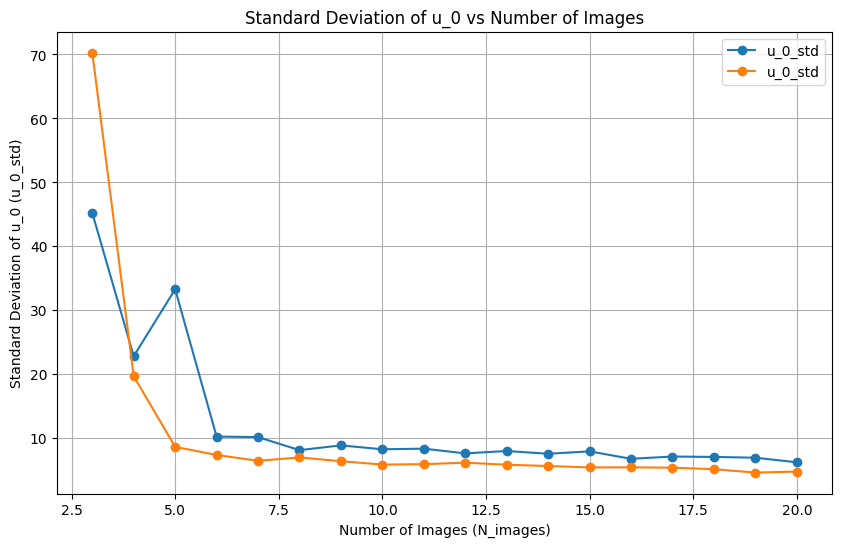

In [508]:
### TODO: select how to compute the standard deviation
## - 1 plot per coordinate
## - combine them together

max_N_images = 20
N_images = list(range(3, max_N_images + 1))
n_samples = 100     # TODO: let's discuss about the quantity

# since V is a stack of two equations per image,
# I can use them to compute K instead of recomputing V each time
index_to_select = list(range(0, len(V), 2))

u0_std = []
v0_std = []

for n_images in range(3, max_N_images + 1):
    current_sample = 1
    principal_point_coord = []
    while current_sample <= n_samples:
        selected_images = np.array(random.sample(index_to_select, n_images))
        _V = np.concatenate([V[selected_images], V[selected_images + 1]])

        # some matrices could be not positive definite -> no solution
        try:
            K = u.get_intrinsic(np.array(_V))
        except:
            continue
        
        principal_point_coord.append([K[0,2], K[1,2]])
        current_sample += 1
    
    principal_point_coord = np.stack(principal_point_coord)
    _u0_std, _v0_std = principal_point_coord.std(axis=0)
    u0_std.append(_u0_std.item())
    v0_std.append(_v0_std.item())
    
    
# TODO: visualization to improve
plt.figure(figsize=(10, 6))
plt.plot(N_images, u0_std, marker='o', label='u_0_std')
plt.plot(N_images, v0_std, marker='o', label='u_0_std')
plt.xlabel('Number of Images (N_images)')
plt.ylabel('Standard Deviation of u_0 (u_0_std)')
plt.title('Standard Deviation of u_0 vs Number of Images')
plt.grid(True)
plt.legend()
plt.show()